In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def mpi4py_total_time_finder(folders):
    tot_times = pd.DataFrame(columns=['Processes','Array','MaxTime'])
    for folder in folders:
        timingsFile = open(folder+'/data2.txt')
        tot_time_line = timingsFile.readline()
        tot_time_array = tot_time_line[tot_time_line.find('[')+1:tot_time_line.find(']')-1]
        tot_time_np = np.array(map(float,tot_time_array.split(',')))
        tot_times.loc[len(tot_times)] = [int(tot_time_line.split(' ')[0]),tot_time_np,tot_time_np.max()]
        timingsFile.close()
    
    return tot_times

def dask_total_time_finder(folders):
    tot_times = pd.DataFrame(columns=['Processes','Time'])
    for folder in folders:
        timingsFile = open(folder+'/data3.txt')
        lines = timingsFile.readlines()
        for line in lines:
            tot_times.loc[len(tot_times)] = [int(line.split(' ')[1]),float(line.split(' ')[-1])]
        timingsFile.close()
        
    return tot_times

def SparkLogToDuration(folders):
    import json
    import pandas
    import numpy as np

    tot_times = pd.DataFrame(columns=['Processes','Time'])
    
    for folder in folders:
        files = glob.glob(folder+'app*')
        for app_file in files:
            stat_file=open(app_file)
            stats=list();
            for line in stat_file:
                stats.append(json.loads(line))
                for stat in stats:
                    if stat['Event'] == 'SparkListenerApplicationStart':
                        start=int(stat['Timestamp'])/1000
                    elif stat['Event'] == 'SparkListenerApplicationEnd':
                        end = int(stat['Timestamp'])/1000
            tot_times.loc[len(tot_times)]=[int(folder.split('/')[1].split('node')[0])*24,end-start]
    return tot_times

In [3]:
folders = glob.glob('mpi4py/24coreExecs/*/')
times_mpi4py = mpi4py_total_time_finder(folders)
times_mpi4py.sort_values(by=['Processes'],inplace=True)
times_mpi4py.reset_index(inplace=True,drop=True)
times_mpi_mean = pd.DataFrame(columns=['Processes','Time'])
times_mpi_mean.loc[0] = times_mpi4py[0:5].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[1] = times_mpi4py[5:10].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[2] = times_mpi4py[10:15].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[3] = times_mpi4py[15:20].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[4] = times_mpi4py[20:25].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[5] = times_mpi4py[25:30].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean.loc[6] = times_mpi4py[30:35].drop('Array',axis=1,inplace=False).mean().values
times_mpi_mean['Speedup'] = times_mpi_mean['Time'][0]/times_mpi_mean['Time'].values

In [4]:
folders = glob.glob('Dask/random/*/')
times_dask = dask_total_time_finder(folders)
times_dask_mean = pd.DataFrame(columns=['Processes','Time'])
times_dask_mean.loc[0] = times_dask[0:4].mean().values
times_dask_mean.loc[1] = times_dask[4:8].mean().values
times_dask_mean.loc[2] = times_dask[8:12].mean().values
times_dask_mean.loc[3] = times_dask[12:16].mean().values
times_dask_mean.loc[4] = times_dask[16:20].mean().values
times_dask_mean.loc[5] = times_dask[20:24].mean().values
times_dask_mean.loc[6] = times_dask[24:28].mean().values
times_dask_mean['Speedup'] = times_dask_mean['Time'][0]/times_dask_mean['Time'].values


In [5]:
folders = glob.glob('Spark/*/')
times_spark = SparkLogToDuration(folders)
times_spark_mean = pd.DataFrame(columns=['Processes','Time'])
times_spark_mean.loc[0] = times_spark[0:5].mean().values
times_spark_mean.loc[1] = times_spark[5:10].mean().values
times_spark_mean.loc[2] = times_spark[10:15].mean().values
times_spark_mean.loc[3] = times_spark[15:20].mean().values
times_spark_mean.loc[4] = times_spark[20:25].mean().values
times_spark_mean.loc[5] = times_spark[25:30].mean().values
times_spark_mean.loc[6] = times_spark[30:35].mean().values
times_spark_mean['Speedup'] = times_spark_mean['Time'][0]/times_spark_mean['Time'].values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x109041810>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1088e9650>], dtype=object)

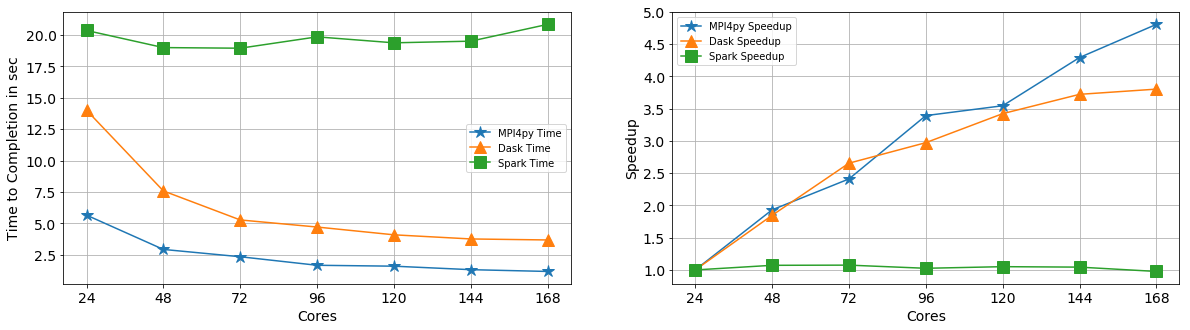

In [6]:
fig,axes = plt.subplots(nrows=1,ncols=2,sharex=True)
fig.set_size_inches(20,5)
axes[0].plot(times_mpi_mean['Processes'],times_mpi_mean['Time'],marker='*',markersize=12,label='MPI4py Time')
axes[0].plot(times_dask_mean['Processes'],times_dask_mean['Time'],marker='^',markersize=12,label='Dask Time')
axes[0].plot(times_spark_mean['Processes'],times_spark_mean['Time'],marker='s',markersize=12,label='Spark Time')
axes[0].set_xscale('linear',base=10)
axes[0].set_yscale('linear',base=10)
axes[0].set_xticks([24,48,72,96,120,144,168])
axes[0].set_xticklabels(['24','48','72','96','120','144','168'],fontsize=14)
axes[0].set_yticklabels(axes[0].get_yticks().astype('str'),fontsize=14)
axes[0].set_ylabel('Time to Completion in sec',fontsize=14)
axes[0].set_xlabel('Cores',fontsize=14)
axes[1].plot(times_mpi_mean['Processes'],times_mpi_mean['Speedup'],marker='*',markersize=12,label='MPI4py Speedup')
axes[1].plot(times_dask_mean['Processes'],times_dask_mean['Speedup'],marker='^',markersize=12,label='Dask Speedup')
axes[1].plot(times_spark_mean['Processes'],times_spark_mean['Speedup'],marker='s',markersize=12,label='Spark Speedup')
axes[1].set_ylabel('Speedup',fontsize=14)
axes[1].set_xticklabels(['24','48','72','96','120','144','168'],fontsize=14)
axes[1].set_yticklabels(axes[1].get_yticks().astype('str'),fontsize=14)
axes[1].set_xlabel('Cores',fontsize=14)
axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[0].grid()
axes[1].grid()
axes
#fig.savefig('MPI4py_Dask_random_array.pdf',dpi=800,bbox_inches='tight')